In [1]:
import time
import pandas as pd
from denmune import DenMune

using NGT, Proximity matrix has been calculated  in:  0.00719904899597168  seconds
Dataset's Groundtruht


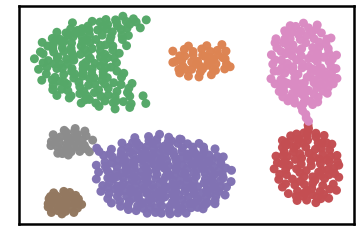



There are 0 outlier point(s) in black (noise of type-1) represent 0% of total points
There are 0 weak point(s) in light grey (noise of type-2) represent 0% of total points
DenMune detected 225 clusters 



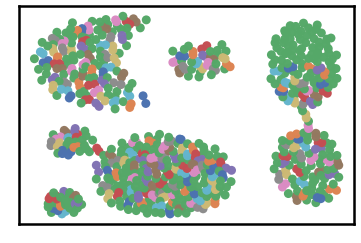

k= 1 :Validity score is: 0.12320616755409444 but best score is 0.12320616755409444 at k= 1     

using NGT, Proximity matrix has been calculated  in:  0.0072247982025146484  seconds
k= 2 :Validity score is: 0.10834819591164768 but best score is 0.12320616755409444 at k= 1     

using NGT, Proximity matrix has been calculated  in:  0.011085987091064453  seconds
There are 16 outlier point(s) in black (noise of type-1) represent 2% of total points
There are 19 weak point(s) in light grey (noise of type-2) represent 2% of total points
DenMune detected 43 clusters 



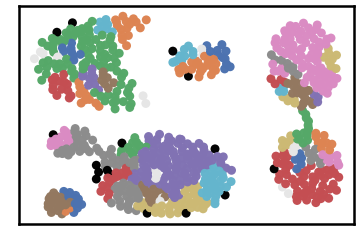

k= 3 :Validity score is: 0.5970123672945185 but best score is 0.5970123672945185 at k= 3     

using NGT, Proximity matrix has been calculated  in:  0.007733345031738281  seconds
There are 7 outlier point(s) in black (noise of type-1) represent 1% of total points
There are 5 weak point(s) in light grey (noise of type-2) represent 1% of total points
DenMune detected 20 clusters 



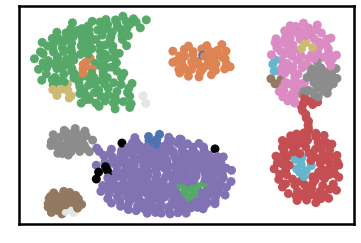

k= 4 :Validity score is: 0.8971268233976194 but best score is 0.8971268233976194 at k= 4     

using NGT, Proximity matrix has been calculated  in:  0.00831151008605957  seconds
There are 0 outlier point(s) in black (noise of type-1) represent 0% of total points
There are 3 weak point(s) in light grey (noise of type-2) represent 0% of total points
DenMune detected 7 clusters 



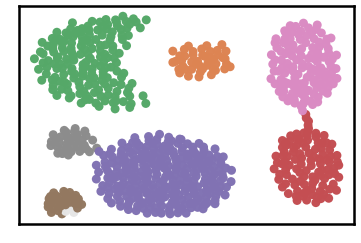

k= 5 :Validity score is: 0.9929458471817214 but best score is 0.9929458471817214 at k= 5     

using NGT, Proximity matrix has been calculated  in:  0.008350372314453125  seconds
There are 0 outlier point(s) in black (noise of type-1) represent 0% of total points
There are 0 weak point(s) in light grey (noise of type-2) represent 0% of total points
DenMune detected 7 clusters 



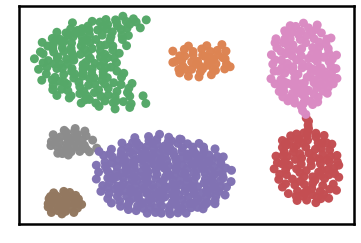

k= 6 :Validity score is: 0.9962034083064701 but best score is 0.9962034083064701 at k= 6     

using NGT, Proximity matrix has been calculated  in:  0.009405136108398438  seconds
k= 7 :Validity score is: 0.9962034083064701 but best score is 0.9962034083064701 at k= 6     

using NGT, Proximity matrix has been calculated  in:  0.009631872177124023  seconds
k= 8 :Validity score is: 0.9962034083064701 but best score is 0.9962034083064701 at k= 6     

using NGT, Proximity matrix has been calculated  in:  0.010422468185424805  seconds
There are 0 outlier point(s) in black (noise of type-1) represent 0% of total points
There are 0 weak point(s) in light grey (noise of type-2) represent 0% of total points
DenMune detected 7 clusters 



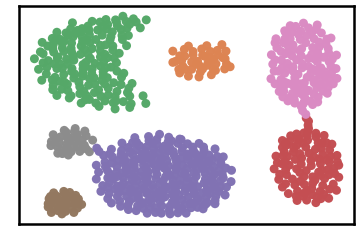

k= 9 :Validity score is: 0.9974644121825882 but best score is 0.9974644121825882 at k= 9     

using NGT, Proximity matrix has been calculated  in:  0.010444879531860352  seconds
k= 10 :Validity score is: 0.9974644121825882 but best score is 0.9974644121825882 at k= 9     

using NGT, Proximity matrix has been calculated  in:  0.010626077651977539  seconds
k= 11 :Validity score is: 0.9949579337028716 but best score is 0.9974644121825882 at k= 9     

using NGT, Proximity matrix has been calculated  in:  0.01184535026550293  seconds
There are 0 outlier point(s) in black (noise of type-1) represent 0% of total points
There are 0 weak point(s) in light grey (noise of type-2) represent 0% of total points
DenMune detected 7 clusters 



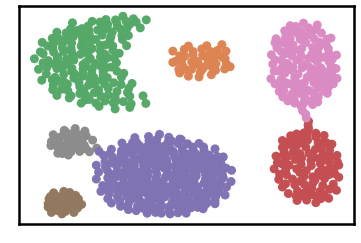

k= 12 :Validity score is: 0.9974706059239578 but best score is 0.9974706059239578 at k= 12     

using NGT, Proximity matrix has been calculated  in:  0.012338638305664062  seconds
k= 13 :Validity score is: 0.9974706059239578 but best score is 0.9974706059239578 at k= 12     

using NGT, Proximity matrix has been calculated  in:  0.014554262161254883  seconds
k= 14 :Validity score is: 0.9974706059239578 but best score is 0.9974706059239578 at k= 12     

using NGT, Proximity matrix has been calculated  in:  0.07326102256774902  seconds
k= 15 :Validity score is: 0.9974706059239578 but best score is 0.9974706059239578 at k= 12     



<Figure size 432x288 with 0 Axes>

In [2]:
# Denmune's Paramaters
# DenMune(dataset=dataset, k_nearest=n, data_path=data_path, verpose=verpose_mode, show_plot=show_plot, show_noise=show_noise)
dataset = 'aggregation' # let us take Aggregation dataset as an example
verpose_mode = True # view in-depth analysis of time complexity and outlier detection, num of clusters
data_path = 'data/' # change it to whatever you put your data, set it to ''; so it will retrive from current folder
show_plot = True  # show plots on/off
show_noise = True # show noise and outlier on/off

# loop's parameters
start = 1
step = 1
end=15

# Validity indexes' parameters
validity_val = -1
best_k = 0
best_val = -1

validity_idx = 2 # Acc=1, F1-score=2,  NMI=3, AMI=4, ARI=5,  Homogeneity=6, and Completeness=7
df = pd.DataFrame(columns =['K', 'ACC', 'F1', 'NMI', 'AMI', 'ARI','Homogeneity', 'Completeness', 'Time' ])


for n in range(start, end+1, step):
    start_time = time.time()
    dm = DenMune(dataset=dataset, k_nearest=n, data_path=data_path, verpose=verpose_mode, show_noise=show_noise)
    labels_true, labels_pred = dm.output_Clusters()
    if show_plot == True and n==start:
        # Let us plot the groundtruth of this dataset which is reduced to 2-d using t-SNE
        print ("Dataset\'s Groundtruht")
        dm.plot_clusters(labels_true, ground=True)
        print('\n', "=====" * 20 , '\n')       
               
    end_time = time.time()
    
    validity_indexes = dm.validate_Clusters(labels_true, labels_pred)
    validity_val = validity_indexes[validity_idx]
    validity_indexes[0] = n
    validity_indexes[8] = end_time - start_time
    
    df = df.append(pd.Series(validity_indexes, index=df.columns ), ignore_index=True)
    
    if (best_val < validity_val):
        best_val = validity_val
        best_k = n
        # Let us show results where only an improve in accuracy is detected
        if show_plot:
            dm.plot_clusters(labels_pred, show_noise=show_noise)
    print ('k=' , n, ':Validity score is:', validity_val , 'but best score is', best_val, 'at k=', best_k , end='     ')
            
    if not verpose_mode:
        print('\r', end='')
    else:
        print('\n', "=====" * 20 , '\n')

In [3]:
# It is time to save the results
para_file = 'denmune'+ '_para_'  + dataset + '.csv'
df.sort_values(by=['F1', 'NMI', 'ARI'] , ascending=False, inplace=True)   
df.to_csv(para_file, index=False, sep='\t', header=True)

In [4]:
df # it is sorted now and saved

,K,ACC,F1,NMI,AMI,ARI,Homogeneity,Completeness,Time
11,12.0,786.0,0.997471,0.991530,0.991408,0.994888,0.992384,0.990678,0.104699
12,13.0,786.0,0.997471,0.991530,0.991408,0.994888,0.992384,0.990678,0.167562
13,14.0,786.0,0.997471,0.991530,0.991408,0.994888,0.992384,0.990678,0.124929
14,15.0,786.0,0.997471,0.991530,0.991408,0.994888,0.992384,0.990678,0.228682
8,9.0,786.0,0.997464,0.992432,0.992323,0.995626,0.992600,0.992265,0.088262
9,10.0,786.0,0.997464,0.992432,0.992323,0.995626,0.992600,0.992265,0.150703
5,6.0,785.0,0.996203,0.988268,0.988098,0.992708,0.989199,0.987339,0.076916
6,7.0,785.0,0.996203,0.988268,0.988098,0.992708,0.989199,0.987339,0.141881
7,8.0,785.0,0.996203,0.988268,0.988098,0.992708,0.989199,0.987339,0.090100
10,11.0,784.0,0.994958,0.985137,0.984922,0.989801,0.986816,0.983464,0.099753
